In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional

In [15]:
@dataclass
class Station:
    """Класс для представления наземной станции"""
    name: str
    x: float
    y: float
    z: float

    @property  # декоратор используется для обращения к методу как к атрибуту экземпляра класса
    def coordinates(self) -> np.ndarray:
        """Функция возвращает координаты станции"""
        return np.array([self.x, self.y, self.z])


In [19]:
class Satellite:
    """Расчет скоростей"""
    def __init__(self, sat_id: str, data: pd.DataFrame, station: Station):
        self.sat_id = sat_id
        self.data = data.reset_index(drop=True)
        self.station = station
        self._time = None
        self._coordinates = None
        self._velocity = None
        self._angular_velocity = None  # вычисляемые атрибуты скрыты, данные о спутнике (public атрибуты) должны быть доступны

    @property
    def time(self) -> np.ndarray:
        """Время в секундах (вычисляется один раз)"""
        if self._time is None:
            self._time = np.arange(len(self.data)) * 30  # шаг 30 сек
        return self._time

    @property
    def coordinates(self) -> np.ndarray:
        """Перевод координат спутника в тип float (вычисляются один раз)"""
        if self._coordinates is None:
            self._coordinates = self.data[['x_sat', 'y_sat', 'z_sat']].astype(float).values
        return self._coordinates

    def calculate_linear_velocity(self) -> np.ndarray:
        """Вычисляет линейную скорость спутника"""
        if self._velocity is None:
            velocity_vectors = np.diff(self.coordinates, axis=0) / 30  # м/с
            self._velocity = np.linalg.norm(velocity_vectors, axis=1)
        return self._velocity

    def calculate_angular_velocity(self) -> np.ndarray:
        """Вычисляет угловую скорость спутника относительно станции"""
        if self._angular_velocity is None:
            # Векторы от станции к спутнику
            vectors = self.coordinates - self.station.coordinates

            # Нормализованные векторы
            norms = np.linalg.norm(vectors, axis=1)
            unit_vectors = vectors / norms[:, None]

            # Углы между последовательными векторами
            dot_products = np.sum(unit_vectors[:-1] * unit_vectors[1:], axis=1)
            angles = np.arccos(np.clip(dot_products, -1.0, 1.0))  # метод сlip уменьшает ошибку последних значений после запятой

            self._angular_velocity = angles / 30  # рад/с
        return self._angular_velocity

    def get_average_velocities(self) -> tuple:
        """Возвращает средние скорости"""
        lin_vel = self.calculate_linear_velocity()
        ang_vel = self.calculate_angular_velocity()

        avg_lin = np.mean(lin_vel)
        avg_ang = np.mean(ang_vel)

        return avg_lin, avg_ang



In [23]:
class Virtualization:
    """<UNK> <UNK> <UNK> <UNK>"""
    def __init__(self, satellite):
           self.satellite = satellite

    def plot_velocities(self, hours: float = 3):
            """Строит графики скоростей"""
            # Ограничиваем данные по времени
            n_points = min(len(self.satellite.data), int(hours * 3600 / 30))
            time_subset = self.satellite.time[1:n_points]
            lin_vel_subset = self.satellite.calculate_linear_velocity()[:n_points-1]
            ang_vel_subset = self.satellite.calculate_angular_velocity()[:n_points-1]

            plt.figure(figsize=(12, 5))

            # График линейной скорости
            plt.subplot(1, 2, 1)
            plt.plot(time_subset, lin_vel_subset)
            plt.title(f'Линейная скорость спутника {self.satellite.sat_id}')
            plt.xlabel('Время (с)')
            plt.ylabel('Скорость (м/с)')
            plt.grid(True)

            # График угловой скорости
            plt.subplot(1, 2, 2)
            plt.plot(time_subset, np.satellite.degrees(ang_vel_subset))
            plt.title(f'Угловая скорость спутника {self.satellite.sat_id}')
            plt.xlabel('Время (с)')
            plt.ylabel('Угловая скорость (град/с)')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

In [24]:
class DataProcessor:
    """Класс для обработки данных и управления спутниками"""

    def __init__(self, filename: str):
        self.filename = filename
        self.df = self._load_data()
        self.station = Station("ONSA", 3370601.790, 711917.542, 5349837.123)
        self.satellites = []

    def _load_data(self) -> pd.DataFrame:
        """Загружает данные из файла"""
        with open(self.filename, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 22:
                data.append(parts)

        columns = [
            'sat_id', 'ro', 'P1', 'P2', 'L1', 'L2', 'Mw', 'Md', 'Td', 'Tw',
            'Tw_estimate', 'dt', 'dTrec_estimate', 'A', 'windup_metr',
            'elevation', 'x_sat', 'y_sat', 'z_sat', 'P3', 'L3', 'R_geom'
        ]

        df = pd.DataFrame(data, columns=columns)
        df[columns[1:]] = df[columns[1:]].astype(float)
        return df

    def create_satellites(self, n: int = 3, hours: float = 3) -> List[Satellite]:
        """Создает объекты спутников"""
        unique_sats = self.df['sat_id'].unique()[:n]
        self.satellites = []

        for sat_id in unique_sats:
            sat_df = self.df[self.df['sat_id'] == sat_id]
            # Ограничиваем по времени (3 часа = 360 эпох)
            sat_df = sat_df.iloc[:min(len(sat_df), int(hours * 3600 / 30))]

            satellite = Satellite(sat_id, sat_df, self.station)
            self.satellites.append(satellite)

        return self.satellites

    def analyze_satellites(self):
        """Проводит полный анализ всех спутников"""
        if not self.satellites:
            self.create_satellites()

        for satellite in self.satellites:
            avg_lin, avg_ang = satellite.get_average_velocities()

            print(
                f'Спутник {satellite.sat_id}: '
                f'средняя линейная скорость = {avg_lin:.2f} м/с, '
                f'средняя угловая = {np.degrees(avg_ang):.6f} град/с'
            )

            satellite.plot_velocities()



Спутник 3: средняя линейная скорость = 3204.39 м/с, средняя угловая = 0.007804 град/с


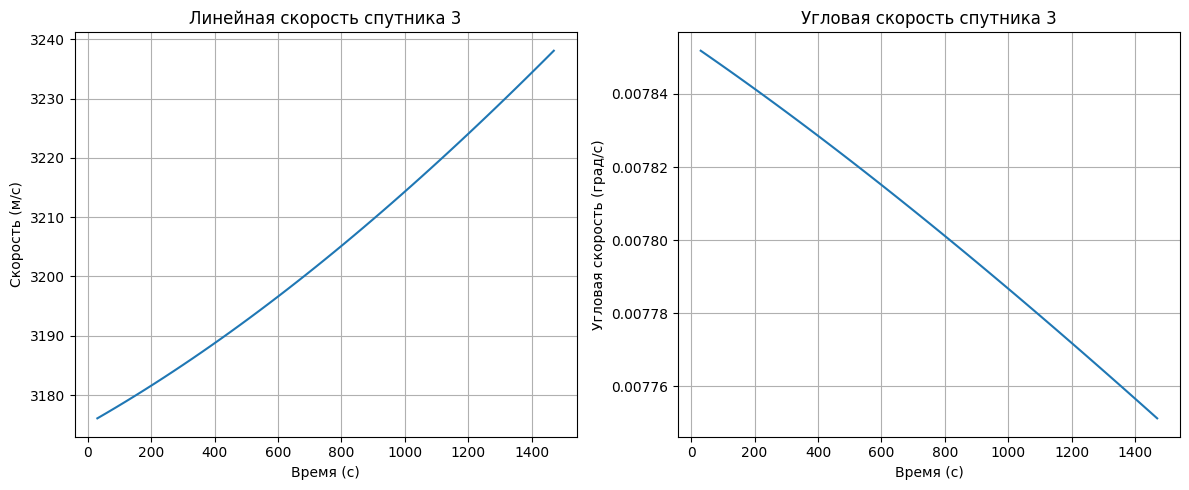

Спутник 4: средняя линейная скорость = 3191.58 м/с, средняя угловая = 0.008001 град/с


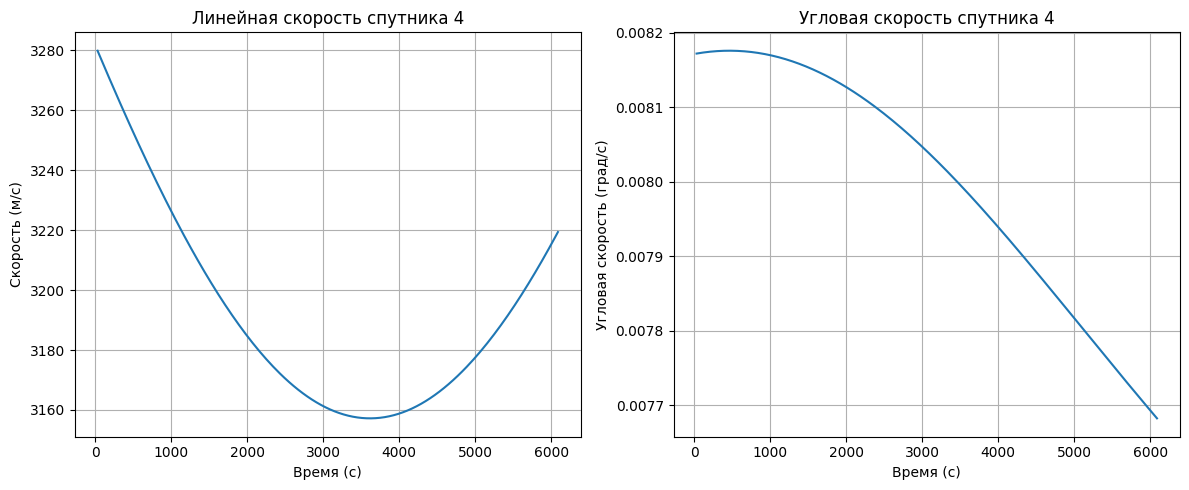

Спутник 10: средняя линейная скорость = 3614.98 м/с, средняя угловая = 0.008978 град/с


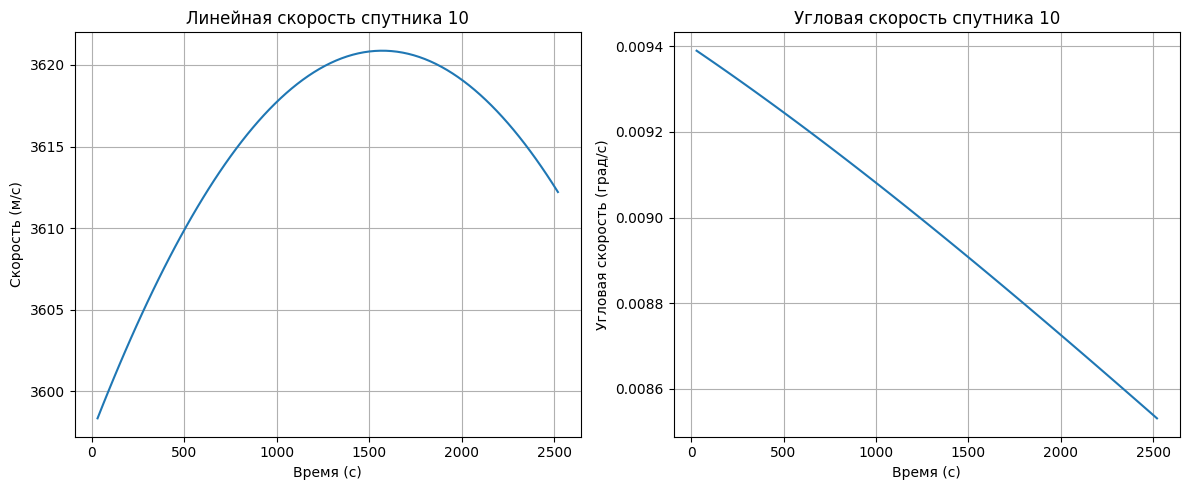

In [25]:
# Использование
def main():
    # Создаем процессор данных
    processor = DataProcessor('ONSA_1-6.dat')

    # Создаем спутники и анализируем
    processor.create_satellites(n=3, hours=3)
    processor.analyze_satellites()

if __name__ == "__main__":
    main()